# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [6]:
!pip install sqlalchemy


     |████████████████████████████████| 1.2 MB 1.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/budweiser/new/bin/python3 -m pip install --upgrade pip' command.


In [9]:
# import libraries
import re
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to /Users/budweiser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/budweiser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/budweiser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('InsertTableName', con=engine)

categories = df.columns[4:]

X = df[['message']].values[:, 0]
y = df[categories].values

### 2. Write a tokenization function to process your text data

In [11]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text, lemmatizer=WordNetLemmatizer()):
    # Detecte URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
    
    # Normalize and tokenize
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", text.lower()))
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return tokens

In [12]:
# Check vocabulary
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)

In [13]:
# Convert vocabulary into pandas.dataframe
keys, values = [], []
for k, v in vect.vocabulary_.items():
    keys.append(k)
    values.append(v)

vocabulary = pd.DataFrame.from_dict({'words': keys, 'counts': values})

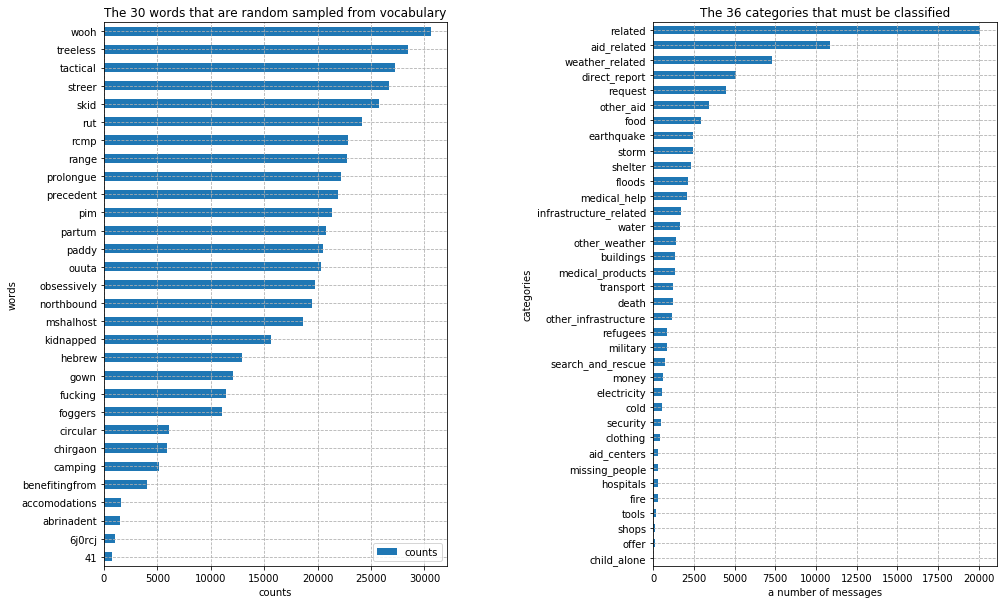

In [14]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(wspace=0.6)

ax1 = plt.subplot(1, 2, 1)
vocabulary.sample(30, random_state=72).sort_values('counts').plot.barh(x='words', y='counts', ax=ax1, colormap='tab10')
plt.title('The 30 words that are random sampled from vocabulary')
plt.xlabel('counts')
plt.grid(linestyle='dashed')

ax2 = plt.subplot(1, 2, 2)
df[categories].sum().sort_values().plot.barh(ax=ax2)
plt.title('The 36 categories that must be classified')
plt.ylabel('categories')
plt.xlabel('a number of messages')
plt.grid(linestyle='dashed')

plt.show()

### 3. Build a machine learning pipeline
- You'll find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [15]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(class_weight='balanced')))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        class_weight='balanced',
                                                                        criterion='gini',
                                                                        max_depth=None,
                                                            

### 5. Test your model
Report the f1 score, precision and recall on both the training set and the test set. You can use sklearn's `classification_report` function here. 

In [18]:
def multioutput_classification_report(y_true, y_pred):
    for i in range(0, len(categories)):
        print(categories[i])
        print("\tAccuracy: {:.4f}\t\t% Precision: {:.4f}\t\t% Recall: {:.4f}\t\t% F1_score: {:.4f}".format(
            accuracy_score(y_true[:, i], y_pred[:, i]),
            precision_score(y_true[:, i], y_pred[:, i], average='weighted'),
            recall_score(y_true[:, i], y_pred[:, i], average='weighted'),
            f1_score(y_true[:, i], y_pred[:, i], average='weighted')
        ))
        #print(classification_report(y_true[:, i], y_pred[:, i]))
        #print("--------------------------------------------------")

In [19]:
y_pred = pipeline.predict(X_train)

In [20]:
multioutput_classification_report(y_train, y_pred)

related
	Accuracy: 0.9979		% Precision: 0.9979		% Recall: 0.9979		% F1_score: 0.9979
request
	Accuracy: 0.9988		% Precision: 0.9988		% Recall: 0.9988		% F1_score: 0.9988
offer
	Accuracy: 0.9999		% Precision: 0.9999		% Recall: 0.9999		% F1_score: 0.9999
aid_related
	Accuracy: 0.9989		% Precision: 0.9989		% Recall: 0.9989		% F1_score: 0.9989
medical_help
	Accuracy: 0.9994		% Precision: 0.9994		% Recall: 0.9994		% F1_score: 0.9994
medical_products
	Accuracy: 0.9995		% Precision: 0.9995		% Recall: 0.9995		% F1_score: 0.9995
search_and_rescue
	Accuracy: 0.9997		% Precision: 0.9997		% Recall: 0.9997		% F1_score: 0.9997
security
	Accuracy: 0.9996		% Precision: 0.9996		% Recall: 0.9996		% F1_score: 0.9996
military
	Accuracy: 0.9997		% Precision: 0.9997		% Recall: 0.9997		% F1_score: 0.9997
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
food
	Accuracy: 0.9998		% Precision

In [21]:
y_pred = pipeline.predict(X_test)

In [22]:
multioutput_classification_report(y_test, y_pred)

related
	Accuracy: 0.8244		% Precision: 0.8107		% Recall: 0.8244		% F1_score: 0.8097
request
	Accuracy: 0.9080		% Precision: 0.9030		% Recall: 0.9080		% F1_score: 0.9005
offer
	Accuracy: 0.9948		% Precision: 0.9903		% Recall: 0.9948		% F1_score: 0.9925
aid_related
	Accuracy: 0.7769		% Precision: 0.7767		% Recall: 0.7769		% F1_score: 0.7768
medical_help
	Accuracy: 0.9229		% Precision: 0.8989		% Recall: 0.9229		% F1_score: 0.8946
medical_products
	Accuracy: 0.9533		% Precision: 0.9464		% Recall: 0.9533		% F1_score: 0.9339
search_and_rescue
	Accuracy: 0.9722		% Precision: 0.9661		% Recall: 0.9722		% F1_score: 0.9591
security
	Accuracy: 0.9805		% Precision: 0.9616		% Recall: 0.9805		% F1_score: 0.9710
military
	Accuracy: 0.9686		% Precision: 0.9609		% Recall: 0.9686		% F1_score: 0.9550
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9558		% Precision: 0.9520		% Recall: 0.9558		% F1_score: 0.9466
food
	Accuracy: 0.9393		% Precision

/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6. Improve your model
Use grid search to find better parameters. 

In [23]:
parameters = {
    'clf__estimator__n_estimators': [20, 50]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=3, scoring='f1_weighted', verbose=3)

In [24]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] clf__estimator__n_estimators=20 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV] ..... clf__estimator__n_estimators=20, score=0.545, total= 3.0min
[CV] clf__estimator__n_estimators=20 .................................


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s


[CV] ..... clf__estimator__n_estimators=20, score=0.541, total= 2.8min
[CV] clf__estimator__n_estimators=20 .................................


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] ..... clf__estimator__n_estimators=20, score=0.541, total= 3.0min
[CV] clf__estimator__n_estimators=50 .................................


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] ..... clf__estimator__n_estimators=50, score=0.548, total= 4.6min
[CV] clf__estimator__n_estimators=50 .................................


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] ..... clf__estimator__n_estimators=50, score=0.549, total= 3.8min
[CV] clf__estimator__n_estimators=50 .................................


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 20.9min finished


[CV] ..... clf__estimator__n_estimators=50, score=0.554, total= 3.8min


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.

In [25]:
y_pred = cv.predict(X_train)

In [26]:
multioutput_classification_report(y_train, y_pred)

related
	Accuracy: 0.9979		% Precision: 0.9979		% Recall: 0.9979		% F1_score: 0.9979
request
	Accuracy: 0.9986		% Precision: 0.9986		% Recall: 0.9986		% F1_score: 0.9986
offer
	Accuracy: 0.9997		% Precision: 0.9997		% Recall: 0.9997		% F1_score: 0.9997
aid_related
	Accuracy: 0.9987		% Precision: 0.9987		% Recall: 0.9987		% F1_score: 0.9987
medical_help
	Accuracy: 0.9990		% Precision: 0.9990		% Recall: 0.9990		% F1_score: 0.9990
medical_products
	Accuracy: 0.9991		% Precision: 0.9991		% Recall: 0.9991		% F1_score: 0.9991
search_and_rescue
	Accuracy: 0.9988		% Precision: 0.9988		% Recall: 0.9988		% F1_score: 0.9988
security
	Accuracy: 0.9992		% Precision: 0.9992		% Recall: 0.9992		% F1_score: 0.9992
military
	Accuracy: 0.9994		% Precision: 0.9994		% Recall: 0.9994		% F1_score: 0.9994
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9998		% Precision: 0.9998		% Recall: 0.9998		% F1_score: 0.9998
food
	Accuracy: 0.9997		% Precision

In [27]:
y_pred = cv.predict(X_test)

In [28]:
multioutput_classification_report(y_test, y_pred)

related
	Accuracy: 0.8258		% Precision: 0.8125		% Recall: 0.8258		% F1_score: 0.8119
request
	Accuracy: 0.9059		% Precision: 0.9012		% Recall: 0.9059		% F1_score: 0.8969
offer
	Accuracy: 0.9948		% Precision: 0.9903		% Recall: 0.9948		% F1_score: 0.9925
aid_related
	Accuracy: 0.7746		% Precision: 0.7738		% Recall: 0.7746		% F1_score: 0.7741
medical_help
	Accuracy: 0.9242		% Precision: 0.9052		% Recall: 0.9242		% F1_score: 0.8953
medical_products
	Accuracy: 0.9545		% Precision: 0.9490		% Recall: 0.9545		% F1_score: 0.9368
search_and_rescue
	Accuracy: 0.9725		% Precision: 0.9688		% Recall: 0.9725		% F1_score: 0.9599
security
	Accuracy: 0.9805		% Precision: 0.9616		% Recall: 0.9805		% F1_score: 0.9710
military
	Accuracy: 0.9681		% Precision: 0.9568		% Recall: 0.9681		% F1_score: 0.9548
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9562		% Precision: 0.9510		% Recall: 0.9562		% F1_score: 0.9491
food
	Accuracy: 0.9373		% Precision

/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [29]:
pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [100, 200]
}

cv_ada = GridSearchCV(estimator=pipeline_ada, param_grid=parameters_ada, cv=3, scoring='f1_weighted', verbose=3)

In [30]:
cv_ada.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.608, total= 3.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.8min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.607, total= 3.8min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.608, total= 3.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.623, total= 6.0min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.622, total= 6.0min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.623, total= 6.1min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.628, total= 3.8min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.630, total= 3.9min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.624, total= 3.8min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.635, total= 6.0min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.639, total= 6.0min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/Users/budweiser/new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 59.2min finished


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.633, total= 5.9min


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [31]:
# Best parameters set
cv_ada.best_params_

{'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}

In [32]:
y_pred = cv_ada.predict(X_train)

In [33]:
multioutput_classification_report(y_train, y_pred)

related
	Accuracy: 0.7380		% Precision: 0.8375		% Recall: 0.7380		% F1_score: 0.7575
request
	Accuracy: 0.8688		% Precision: 0.8881		% Recall: 0.8688		% F1_score: 0.8755
offer
	Accuracy: 0.9650		% Precision: 0.9961		% Recall: 0.9650		% F1_score: 0.9787
aid_related
	Accuracy: 0.7838		% Precision: 0.7826		% Recall: 0.7838		% F1_score: 0.7826
medical_help
	Accuracy: 0.8981		% Precision: 0.9296		% Recall: 0.8981		% F1_score: 0.9099
medical_products
	Accuracy: 0.9049		% Precision: 0.9539		% Recall: 0.9049		% F1_score: 0.9230
search_and_rescue
	Accuracy: 0.8687		% Precision: 0.9716		% Recall: 0.8687		% F1_score: 0.9096
security
	Accuracy: 0.8757		% Precision: 0.9820		% Recall: 0.8757		% F1_score: 0.9198
military
	Accuracy: 0.9597		% Precision: 0.9778		% Recall: 0.9597		% F1_score: 0.9660
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9517		% Precision: 0.9662		% Recall: 0.9517		% F1_score: 0.9564
food
	Accuracy: 0.9532		% Precision

In [34]:
y_pred = cv_ada.predict(X_test)

In [35]:
multioutput_classification_report(y_test, y_pred)

related
	Accuracy: 0.7185		% Precision: 0.8232		% Recall: 0.7185		% F1_score: 0.7405
request
	Accuracy: 0.8578		% Precision: 0.8812		% Recall: 0.8578		% F1_score: 0.8660
offer
	Accuracy: 0.9548		% Precision: 0.9908		% Recall: 0.9548		% F1_score: 0.9722
aid_related
	Accuracy: 0.7608		% Precision: 0.7591		% Recall: 0.7608		% F1_score: 0.7592
medical_help
	Accuracy: 0.8850		% Precision: 0.9191		% Recall: 0.8850		% F1_score: 0.8984
medical_products
	Accuracy: 0.8897		% Precision: 0.9451		% Recall: 0.8897		% F1_score: 0.9116
search_and_rescue
	Accuracy: 0.8438		% Precision: 0.9575		% Recall: 0.8438		% F1_score: 0.8925
security
	Accuracy: 0.8508		% Precision: 0.9693		% Recall: 0.8508		% F1_score: 0.9028
military
	Accuracy: 0.9483		% Precision: 0.9698		% Recall: 0.9483		% F1_score: 0.9567
child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
water
	Accuracy: 0.9437		% Precision: 0.9633		% Recall: 0.9437		% F1_score: 0.9502
food
	Accuracy: 0.9475		% Precision

### 9. Export your model as a pickle file

In [36]:
with open('adaboost_cv.pkl', 'wb') as file:
    pickle.dump(cv_ada, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.